LCO Photometric Calibration Script
=============================

Using the OzDES standard star catalogue

In [1]:
#first import the relevant modules 

from astropy.io import fits #to read in fits file
import matplotlib.pyplot as plt #to plot
import aplpy #to plot the fits file in the correct colour scale easily
import numpy as np #data table handling
from astropy import wcs #convert x and y to ra and dec
import pandas as pd #to read in csv file
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky # used for matching 
from astropy import units as u #used in matching process also 

from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import glob

import subprocess

## Photometry

In [2]:
#Reads all the photometric files (they end with .fz)

hdu = []
for each_file in glob.glob('*.fz'):
    hdu.append(fits.open(each_file))
    
All_hdu_header = []
All_cats_data = []


#store the header and the data in a separate list
for i in hdu:
    All_hdu_header.append(i[1].header)
    All_cats_data.append(i[2].data)
    
#combine the list to have easy access to to the data and header
All_photo = [All_cats_data,All_hdu_header]

In [3]:
#Checking if need to add zero point information if new telescope used.
for i in range(len(All_photo[0])):
    if All_photo[1][i]['TELID']!='1m0a':
        print(All_photo[1][i]['SITE'],All_photo[1][i]['TELID'])

In [4]:
#Locating where the object is in the photo:

#first provide the known location of each object:
NGC3783_loc = np.array([174.7571232337532, -37.7386134993465]) #From LCO observation portal
IC4329A_loc = np.array([207.3302530340835, -30.3095067046753])
IRAS091496206_loc = np.array([139.039025905958,-62.3248777195977])
Fairall51_loc = np.array([281.224955700999,-62.3646865952261])


#Then define a function that looks for the object based on the coordinate to the nearest 0.001ra and 0.001dec,
#which then returns its flux and flux error.
def fluxes_and_fluxerr(input_object):
    #The input object will be the list named 'All_photos' created earlier.
    #Recall that its first element is a list of all the data and its second element is a list of all the headers.
    fluxes = []
    fluxerr = []
    for j in range(len(input_object[0])): 
        for i in range(len(input_object[0][j]['ra'])):
            if input_object[1][j]['OBJECT']=='NGC3783':
                if (-1e-3<input_object[0][j]['ra'][i]-NGC3783_loc[0]<1e-3) and -1e-3<input_object[0][j]['dec'][i]-NGC3783_loc[1]<1e-3:
                    fluxes.append(input_object[0][j]['flux'][i])
                    fluxerr.append(input_object[0][j]['fluxerr'][i])
            if input_object[1][j]['OBJECT']=='IC4329A':
                if (-1e-3<input_object[0][j]['ra'][i]-IC4329A_loc[0]<1e-3) and -1e-3<input_object[0][j]['dec'][i]-IC4329A_loc[1]<1e-3:
                    fluxes.append(input_object[0][j]['flux'][i])
                    fluxerr.append(input_object[0][j]['fluxerr'][i])
            if input_object[1][j]['OBJECT']=='IRAS09149-6206':
                if (-1e-3<input_object[0][j]['ra'][i]-IRAS091496206_loc[0]<1e-3) and -1e-3<input_object[0][j]['dec'][i]-IRAS091496206_loc[1]<1e-3:
                    fluxes.append(input_object[0][j]['flux'][i])
                    fluxerr.append(input_object[0][j]['fluxerr'][i])
            if input_object[1][j]['OBJECT']=='Fairall51':
                if (-1e-3<input_object[0][j]['ra'][i]-Fairall51_loc[0]<1e-3) and -1e-3<input_object[0][j]['dec'][i]-Fairall51_loc[1]<1e-3:
                    fluxes.append(input_object[0][j]['flux'][i])
                    fluxerr.append(input_object[0][j]['fluxerr'][i])
    return (fluxes,fluxerr)


In [5]:
#Finding the Zero Point Magnitude for each telescope

def zeropoint (input_object):
    zp = []
    for i in range(len(input_object[1])):
        observatory = input_object[1][i]['SITE']
        telescope = input_object[1][i]['TELID']
        lens = input_object[1][i]['FILTER']
        if observatory == 'LCOGT node at SAAO':
            if telescope == '1m0a':
                if lens == 'gp':
                    zp.append(23.00)
                if lens == 'ip':
                    zp.append(22.10)
                if lens == 'rp':
                    zp.append(22.75)
        if observatory == 'LCOGT node at Siding Spring Observatory': #both telescopes are the same
            if lens == 'gp':
                zp.append(23.05)
            if lens == 'ip':
                zp.append(22.10)
            if lens == 'rp':
                zp.append(22.80)
        if observatory == 'LCOGT node at Cerro Tololo Inter-American Observatory':
            if telescope == '1m0a':
                if lens == 'gp':
                    zp.append(23.05)
                if lens == 'ip':
                    zp.append(22.15)
                if lens == 'rp':
                    zp.append(22.80)
    return (zp)

In [6]:
#so now we have to calculate the mag and mag errs of each object in cat in the three filters
# and then we can find the difference in mag from the OzDES catalogue. 

def mag_err_t(galaxy): 
    '''Returns the mag and mag error as a numpy array given a mag zeropoint, array of fluxes and flux errors.'''
    mag_zp = zeropoint(galaxy)
    fluxes,flux_errs = fluxes_and_fluxerr(galaxy)
    
    mags = []
    mag_errs = []
    time = []
    for i in range(0,len(fluxes)):
        if fluxes[i] > 0: 
            mag = mag_zp[i] - (2.5*np.log10(fluxes[i]))
            mag_err = (2.5/np.log(10)) * (flux_errs[i]/fluxes[i])
            mags.append(mag)
            mag_errs.append(mag_err)
            time.append(galaxy[1][i]['MJD-OBS'])
        else: 
            mag = 99.0 
            mag_err = 99.0 
            mags.append(mag)
            mag_errs.append(mag_err)
    return mags,mag_errs,time


In [7]:
#runs the code
photo_mag, photo_err, photo_time = mag_err_t(All_photo) 

# and saves the magnitudes, err, time into a new list
photo = np.array([photo_mag, photo_err, photo_time])

In [8]:
#order files by date
photo_ind = np.argsort(photo[2])
photo[0] = photo[0][photo_ind]
photo[1] = photo[1][photo_ind]
photo[2] = photo[2][photo_ind]

#The original All_photo file which contain all the headers
Al_photo = np.array(All_photo[1],dtype=object)
Al_photo = Al_photo[photo_ind]


#sorting by galaxy and filter.
NGC_g = np.array([[],[],[]])
NGC_r = np.array([[],[],[]])
NGC_i = np.array([[],[],[]])

IC_g = np.array([[],[],[]])
IC_r = np.array([[],[],[]])
IC_i = np.array([[],[],[]])

IRAS_g = np.array([[],[],[]])
IRAS_r = np.array([[],[],[]])
IRAS_i = np.array([[],[],[]])

Fairall_g = np.array([[],[],[]])
Fairall_r = np.array([[],[],[]])
Fairall_i = np.array([[],[],[]])


for i in range(len(photo[0])):
    if Al_photo[i]['OBJECT'] == 'NGC3783':
        if Al_photo[i]['FILTER'] == 'gp':
            NGC_g = np.concatenate((NGC_g , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'rp':
            NGC_r = np.concatenate((NGC_r , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'ip':
            NGC_i = np.concatenate((NGC_i , np.array([photo[:,i]]).T), axis=1)
    
    if Al_photo[i]['OBJECT'] == 'IC4329A':
        if Al_photo[i]['FILTER'] == 'gp':
            IC_g = np.concatenate((IC_g , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'rp':
            IC_r = np.concatenate((IC_r , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'ip':
            IC_i = np.concatenate((IC_i , np.array([photo[:,i]]).T), axis=1)
        
            
    if Al_photo[i]['OBJECT'] == 'IRAS09149-6206':
        if Al_photo[i]['FILTER'] == 'gp':
            IRAS_g = np.concatenate((IRAS_g , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'rp':
            IRAS_r = np.concatenate((IRAS_r , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'ip':
            IRAS_i = np.concatenate((IRAS_i , np.array([photo[:,i]]).T), axis=1)
            
    if Al_photo[i]['OBJECT'] == 'Fairall51':
        if Al_photo[i]['FILTER'] == 'gp':
            Fairall_g = np.concatenate((Fairall_g , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'rp':
            Fairall_r = np.concatenate((Fairall_r , np.array([photo[:,i]]).T), axis=1)
        if Al_photo[i]['FILTER'] == 'ip':
            Fairall_i = np.concatenate((Fairall_i , np.array([photo[:,i]]).T), axis=1)
print(len(IC_i[0]))

22


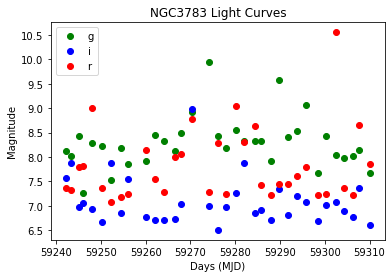

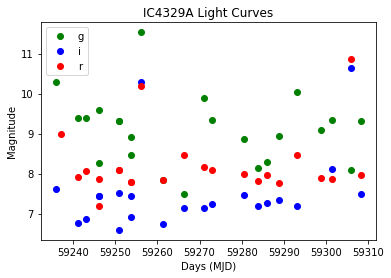

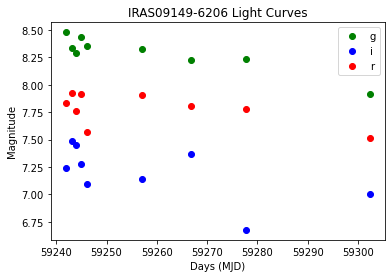

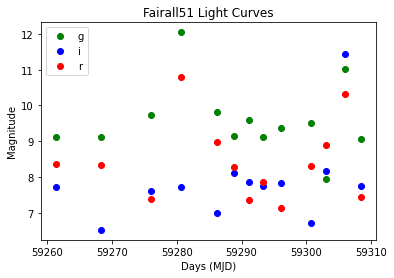

In [9]:
#Plotting to se
plt.plot(NGC_g[2],NGC_g[0],'og',label = 'g')
plt.plot(NGC_i[2],NGC_i[0],'ob',label = 'i')
plt.plot(NGC_r[2],NGC_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('NGC3783 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(IC_g[2],IC_g[0],'og',label = 'g')
plt.plot(IC_i[2],IC_i[0],'ob',label = 'i')
plt.plot(IC_r[2],IC_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('IC4329A Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(IRAS_g[2],IRAS_g[0],'og',label = 'g')
plt.plot(IRAS_i[2],IRAS_i[0],'ob',label = 'i')
plt.plot(IRAS_r[2],IRAS_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('IRAS09149-6206 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(Fairall_g[2],Fairall_g[0],'og',label = 'g')
plt.plot(Fairall_i[2],Fairall_i[0],'ob',label = 'i')
plt.plot(Fairall_r[2],Fairall_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('Fairall51 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

## Not sure if some of the points are outliers. If outliers, run the next 2 cells (modifying the next one so that it removes the outliers). If not, skip the next 2 cells.

In [72]:
#Removing outlier
outlier_ind = np.argmax((NGC_g[0]))   #records the index that gives the highest mag
NGC_g=np.delete(NGC_g, np.s_[outlier_ind], 1) #delete that index
NGC_r=np.delete(NGC_r, np.s_[outlier_ind], 1)
NGC_i=np.delete(NGC_i, np.s_[outlier_ind], 1)

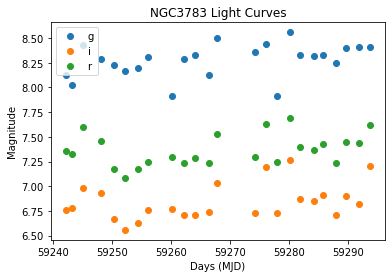

In [73]:
#Check again
#Plotting and remove outliers
plt.plot(NGC_g[2],NGC_g[0],'og',label = 'g')
plt.plot(NGC_i[2],NGC_i[0],'ob',label = 'i')
plt.plot(NGC_r[2],NGC_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('NGC3783 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(IC_g[2],IC_g[0],'og',label = 'g')
plt.plot(IC_i[2],IC_i[0],'ob',label = 'i')
plt.plot(IC_r[2],IC_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('IC4329A Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(IRAS_g[2],IRAS_g[0],'og',label = 'g')
plt.plot(IRAS_i[2],IRAS_i[0],'ob',label = 'i')
plt.plot(IRAS_r[2],IRAS_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('IRAS09149-6206 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

plt.plot(Fairall_g[2],Fairall_g[0],'og',label = 'g')
plt.plot(Fairall_i[2],Fairall_i[0],'ob',label = 'i')
plt.plot(Fairall_r[2],Fairall_r[0],'or',label = 'r')
#plt.errorbar(NGC_g[0][3:],NGC_g[2][3:],yerr=NGC_g[1][3:], linestyle = "None")
#plt.errorbar(NGC_i[0][3:],NGC_i[2][3:],yerr=NGC_i[1][3:], linestyle = "None")
#plt.errorbar(NGC_r[0][3:],NGC_r[2][3:],yerr=NGC_r[1][3:], linestyle = "None")
plt.ylabel('Magnitude')
plt.xlabel('Days (MJD)')
plt.title('Fairall51 Light Curves')
plt.legend()
#plt.savefig("NGC Light Curves.pdf")
plt.show()

In [10]:
#Combining everything to save to a file
NGC3783_mag = np.array([NGC_g[0],NGC_r[0],NGC_i[0]],dtype=object).ravel().tolist()
NGC3783_err = np.array([NGC_g[1],NGC_r[1],NGC_i[1]],dtype=object).ravel().tolist()
NGC3783_mjd = np.array([NGC_g[2],NGC_r[2],NGC_i[2]],dtype=object).ravel().tolist()

IC4329A_mag = np.array([IC_g[0],IC_r[0],IC_i[0]],dtype=object).ravel().tolist()
IC4329A_mag = IC4329A_mag[0].tolist()+IC4329A_mag[1].tolist()+IC4329A_mag[2].tolist() #because previous line wasn't working
IC4329A_err = np.array([IC_g[1],IC_r[1],IC_i[1]],dtype=object).ravel().tolist()
IC4329A_err = IC4329A_err[0].tolist()+IC4329A_err[1].tolist()+IC4329A_err[2].tolist()
IC4329A_mjd = np.array([IC_g[2],IC_r[2],IC_i[2]],dtype=object).ravel().tolist()
IC4329A_mjd = IC4329A_mjd[0].tolist()+IC4329A_mjd[1].tolist()+IC4329A_mjd[2].tolist() #same here

IRAS09149_6206_mag = np.array([IRAS_g[0],IRAS_r[0],IRAS_i[0]],dtype=object).ravel().tolist()
IRAS09149_6206_err = np.array([IRAS_g[1],IRAS_r[1],IRAS_i[1]],dtype=object).ravel().tolist()
IRAS09149_6206_mjd = np.array([IRAS_g[2],IRAS_r[2],IRAS_i[2]],dtype=object).ravel().tolist()

Fairall51_mag = np.array([Fairall_g[0],Fairall_r[0],Fairall_i[0]],dtype=object).ravel().tolist()
Fairall51_err = np.array([Fairall_g[1],Fairall_r[1],Fairall_i[1]],dtype=object).ravel().tolist()
Fairall51_mjd = np.array([Fairall_g[2],Fairall_r[2],Fairall_i[2]],dtype=object).ravel().tolist()


#create the column for filters

NGC_filters = []
IC_filters = []
IRAS_filters = []
Fairall_filters = []

filter_types = ['gp','rp','ip']
for j in range(len(filter_types)):
    for i in range(len(NGC_g[0])):
        NGC_filters.append(filter_types[j])
    for i in range(len(IC_g[0])):
        IC_filters.append(filter_types[j])
    for i in range(len(IRAS_g[0])):
        IRAS_filters.append(filter_types[j])
    for i in range(len(Fairall_g[0])):
        Fairall_filters.append(filter_types[j])

#print(len(IC4329A_mag))
#print(IC_g[2])
#print(IC_r[2])
#print(IC_i[2])
#print(IC4329A_mjd[19],IC4329A_mjd[42])
#print(IC4329A_err)

#an extra point I needed to delete to keep the code running smooth
del IC4329A_mag[42]
del IC4329A_mjd[42]
del IC4329A_err[42]
del IC_filters[42]
del IC4329A_mag[19]
del IC4329A_mjd[19]
del IC4329A_err[19]
del IC_filters[19]
del IC_filters[-1]

print(len(IC4329A_mag))
print(len(IC4329A_err))
print(len(IC4329A_mjd))
print(len(IC_filters))

66
66
66
66


In [11]:
#Check whether the number of each galaxy matches the input. If differs, tighten the restriction on location:

#Original number of the object:

#input example: check_length('NGC3783',NGC3783_mag)
def check_length(input_galaxy, final_file):
    orig_galaxy = []
    for i in range(len(All_photo[0])):
        if All_photo[1][i]['OBJECT'] == input_galaxy:
            orig_galaxy.append(1)
    if len(orig_galaxy) != len(final_file):
        print('Original length is',len(orig_galaxy),', final length is',len(final_file),', needs fixing')
        
    else:
        print('Length match for',input_galaxy)


check_length('NGC3783',NGC3783_mag)
check_length('IC4329A',IC4329A_mag)
check_length('IRAS09149-6206',IRAS09149_6206_mag)
check_length('Fairall51',Fairall51_mag)

Length match for NGC3783
Original length is 69 , final length is 66 , needs fixing
Length match for IRAS09149-6206
Length match for Fairall51


In [12]:
#Create output file
NGC_file = pd.DataFrame(data={'MJD': NGC3783_mjd, 'MAG': NGC3783_mag, 'MAGERR':NGC3783_err, 'BAND':NGC_filters})
NGC_file.to_csv('../NGC3783_lc.dat', index=False)
IC_file = pd.DataFrame(data={'MJD': IC4329A_mjd, 'MAG': IC4329A_mag, 'MAGERR':IC4329A_err, 'BAND':IC_filters})
IC_file.to_csv('../IC4329A_lc.dat', index=False)
IRAS_file = pd.DataFrame(data={'MJD': IRAS09149_6206_mjd, 'MAG': IRAS09149_6206_mag, 'MAGERR':IRAS09149_6206_err, 'BAND':IRAS_filters})
IRAS_file.to_csv('../IRAS09149_6206_lc.dat', index=False)
Fairall_file = pd.DataFrame(data={'MJD': Fairall51_mjd, 'MAG': Fairall51_mag, 'MAGERR':Fairall51_err, 'BAND':Fairall_filters})
Fairall_file.to_csv('../Fairall51_lc.dat', index=False)

In [13]:
#Read file
NGC = pd.read_csv('../NGC3783_lc.dat')
NGC_photo = np.array([NGC['MAG'],NGC['MAGERR'],NGC['MJD'],NGC['BAND']])

IC = pd.read_csv('../IC4329A_lc.dat')
IC_photo = np.array([IC['MAG'],IC['MAGERR'],IC['MJD'],IC['BAND']])

IRAS = pd.read_csv('../IRAS09149_6206_lc.dat')
IRAS_photo = np.array([IRAS['MAG'],IRAS['MAGERR'],IRAS['MJD'],IRAS['BAND']])

Fairall = pd.read_csv('../IRAS09149_6206_lc.dat')
Fairall_photo = np.array([Fairall['MAG'],Fairall['MAGERR'],Fairall['MJD'],Fairall['BAND']])

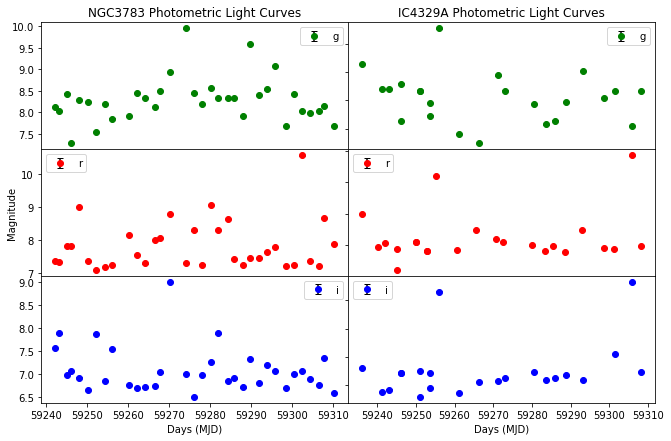

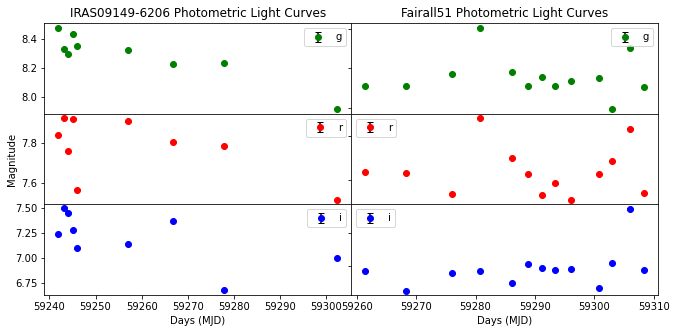

In [45]:
fig, ((NGC_axs0, IC_axs0),
      (NGC_axs1, IC_axs1),
      (NGC_axs2, IC_axs2),
     ) = plt.subplots(3, 2,gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(11, 5))

#fig = plt.figure()
##gs = fig.add_gridspec(3, hspace=0)
#NGC_axs = gs.subplots(sharex=True)
NGC_axs0.errorbar(NGC_g[2],NGC_g[0],yerr=NGC_g[1],fmt = 'og',ecolor='black',capsize=3)
NGC_axs0.set(ylabel='', xlabel='Days (MJD)', title='NGC3783 Photometric Light Curves')
NGC_axs0.legend(['g','err'])
NGC_axs1.errorbar(NGC_r[2],NGC_r[0],yerr=NGC_r[1],fmt = 'or',ecolor='black',capsize=3)
NGC_axs1.set(ylabel='Magnitude', xlabel='Days (MJD)', title='')
NGC_axs1.legend('r')
NGC_axs2.errorbar(NGC_i[2],NGC_i[0],yerr=NGC_i[1],fmt = 'ob',ecolor='black',capsize=3)
NGC_axs2.set(ylabel='', xlabel='Days (MJD)', title='')
NGC_axs2.legend('i')
fig.set_figheight(7)

#plt.savefig('../NGC_photo.pdf')
#plt.show()

#fig = plt.figure()
#gs1 = fig.add_gridspec(3, hspace=0)
#IC_axs = gs1.subplots(sharex=True)
IC_axs0.errorbar(IC_g[2],IC_g[0],yerr=IC_g[1],fmt = 'og',ecolor='black',capsize=3)
IC_axs0.set(ylabel='', xlabel='Days (MJD)', title='IC4329A Photometric Light Curves')
IC_axs0.legend('g')
IC_axs1.errorbar(IC_r[2],IC_r[0],yerr=IC_r[1],fmt = 'or',ecolor='black',capsize=3)
IC_axs1.set(ylabel='Magnitude', xlabel='Days (MJD)', title='')
IC_axs1.legend('r')
IC_axs2.errorbar(IC_i[2],IC_i[0],yerr=IC_i[1],fmt = 'ob',ecolor='black',capsize=3)
IC_axs2.set(ylabel='', xlabel='Days (MJD)', title='')
IC_axs2.legend('i')
#fig.set_figheight(7)
#for ax in IC_axs:
    #ax.label_outer()
#plt.savefig('../IC_photo.pdf')
#plt.show()

for ax in fig.get_axes():
    ax.label_outer()
    
fig, (
      (IRAS_axs0, F_axs0),
      (IRAS_axs1, F_axs1),
      (IRAS_axs2, F_axs2)
     ) = plt.subplots(3, 2,gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(11, 5))

#fig = plt.figure()
#gs2 = fig.add_gridspec(3, hspace=0)
#IRAS_axs = gs2.subplots(sharex=True)
IRAS_axs0.errorbar(IRAS_g[2],IRAS_g[0],yerr=IRAS_g[1],fmt = 'og',ecolor='black',capsize=3)
IRAS_axs0.set(ylabel='', xlabel='Days (MJD)', title='IRAS09149-6206 Photometric Light Curves')
IRAS_axs0.legend('g')
IRAS_axs1.errorbar(IRAS_r[2],IRAS_r[0],yerr=IRAS_r[1],fmt = 'or',ecolor='black',capsize=3)
IRAS_axs1.set(ylabel='Magnitude', xlabel='Days (MJD)', title='')
IRAS_axs1.legend('r')
IRAS_axs2.errorbar(IRAS_i[2],IRAS_i[0],yerr=IRAS_i[1],fmt = 'ob',ecolor='black',capsize=3)
IRAS_axs2.set(ylabel='', xlabel='Days (MJD)', title='')
IRAS_axs2.legend('i')
#fig.set_figheight(7)
#for ax in IRAS_axs:
    #ax.label_outer()
#plt.savefig('../IRAS_photo.pdf')
#plt.show()

#fig = plt.figure()
#gs3 = fig.add_gridspec(3, hspace=0)
#F_axs = gs3.subplots(sharex=True)
F_axs0.errorbar(Fairall_g[2],Fairall_g[0],yerr=Fairall_g[1],fmt = 'og',ecolor='black',capsize=3)
F_axs0.set(ylabel='', xlabel='Days (MJD)', title='Fairall51 Photometric Light Curves')
F_axs0.legend('g')
F_axs1.errorbar(Fairall_r[2],Fairall_r[0],yerr=Fairall_r[1],fmt = 'or',ecolor='black',capsize=3)
F_axs1.set(ylabel='', xlabel='Days (MJD)', title='')
F_axs1.legend('r')
F_axs2.errorbar(Fairall_i[2],Fairall_i[0],yerr=Fairall_i[1],fmt = 'ob',ecolor='black',capsize=3)
F_axs2.set(ylabel='', xlabel='Days (MJD)', title='')
F_axs2.legend('i')
#fig.set_figheight(12)
#for ax in F_axs:
    #ax.label_outer()
#plt.savefig('../Fairall_photo.pdf')
#plt.show()

for ax in fig.get_axes():
    ax.label_outer()
plt.show()

## Spectra

In [46]:
# Define where the transmission function is stored, the bands used, and the centers of each band
bands = ['gp', 'rp', 'ip']
filters = {'gp': '/Users/jchung1/Desktop/Uni Works/ASC/Brad Tucker/Data/All/sdss.gp.txt',
           'rp': '/Users/jchung1/Desktop/Uni Works/ASC/Brad Tucker/Data/All/sdss.rp.txt',
           'ip': '/Users/jchung1/Desktop/Uni Works/ASC/Brad Tucker/Data/All/sdss.ip.txt'}
centers = [4770, 6215, 7545]

# Define where the spectrum is stored
spectra = []
for each_file in glob.glob('*.fits'):
    spectra.append(fits.open(each_file))
    
#creating lists to store useful information
spectra_header = []
spectra_data = []
maxwl = []
minwl = []
spectra_wavelength = []
spectra_variance = []
spectra_date = []
spectra_galaxy = []

#print(len(spectra))

for i in range(len(spectra)):
    spectra_header.append(spectra[i][0].header)
    spectra_data.append(spectra[i][0].data[0][0])
    spectra_variance.append(spectra[i][0].data[3][0])
    spectra_date.append(spectra_header[i]['MJD-OBS'])
    spectra_galaxy.append(spectra_header[i]['OBJECT'])
    maxwl.append(float(spectra_header[i]['XMAX']))
    minwl.append(float(spectra_header[i]['XMIN']))
    spectra_wavelength.append(np.linspace(minwl[i],maxwl[i],len(spectra_data[i])))

#combining the lists for easy access 
spectra = np.array([spectra_data,spectra_variance,spectra_wavelength,spectra_date,spectra_galaxy,spectra_header],dtype = object)

#0: flux
#1: var
#2: wavelength
#3: date
#4: galaxy
#5: header information

16


In [47]:
#sort by date
spectra_ind = np.argsort(spectra[3])
spectra[0] = spectra[0][spectra_ind]
spectra[1] = spectra[1][spectra_ind]
spectra[2] = spectra[2][spectra_ind]
spectra[3] = spectra[3][spectra_ind]
spectra[4] = spectra[4][spectra_ind]
spectra[5] = spectra[5][spectra_ind]
#print(spectra[4])

['IC4329A' 'NGC3783' 'IRAS09149-6206' 'NGC3783' 'NGC3783' 'Fairall51'
 'Fairall51' 'IRAS09149-6206' 'IC4329A' 'NGC3783' 'IRAS09149-6206'
 'NGC3783' 'IC4329A' 'NGC3783' 'IC4329A' 'NGC3783']


In [48]:
#Separate by galaxy
NGC_spectra = np.array([[],[],[],[],[],[]])
IC_spectra = np.array([[],[],[],[],[],[]])
IRAS_spectra = np.array([[],[],[],[],[],[]])
Fairall_spectra = np.array([[],[],[],[],[],[]])

for i in range(len(spectra[0])):
    if spectra[4][i] == 'NGC3783':
        NGC_spectra = np.concatenate((NGC_spectra , np.array([spectra[:,i]]).T), axis=1)
    if spectra[4][i] == 'IC4329A':
        IC_spectra = np.concatenate((IC_spectra , np.array([spectra[:,i]]).T), axis=1)
    if spectra[4][i] == 'IRAS09149-6206':
        IRAS_spectra = np.concatenate((IRAS_spectra , np.array([spectra[:,i]]).T), axis=1)
    if spectra[4][i] == 'Fairall51':
        Fairall_spectra = np.concatenate((Fairall_spectra , np.array([spectra[:,i]]).T), axis=1)
#print(NGC_spectra[5][0]['RA'])

11:39:04.587


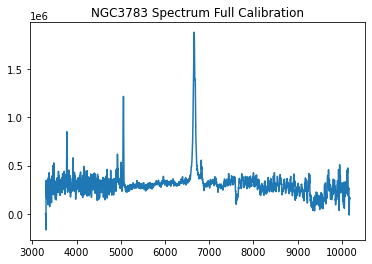

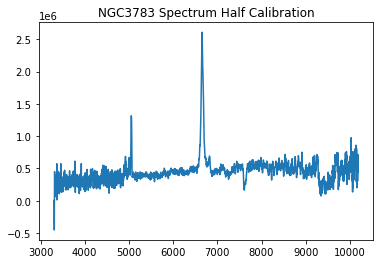

In [49]:
#Showing the difference between full calibrated and half calibrated spectrum

plt.plot(Fairall_spectra[2][1],Fairall_spectra[0][1])
plt.title('NGC3783 Spectrum Full Calibration')
plt.show()

plt.plot(Fairall_spectra[2][0],Fairall_spectra[0][0])
plt.title('NGC3783 Spectrum Half Calibration')
plt.show()


In [50]:
#Read and store the transmission function

class filterCurve:
    """A filter"""

    def __init__(self):
        self.wave = np.array([], 'float')
        self.trans = np.array([], 'float')
        return

    def read(self, file):
        factor = 10 #Transmission file given in nm
        
        file = open(file, 'r')
        for line in file.readlines():
            if line[1] != "l":
                entries = line.split()
                self.wave = np.append(self.wave, float(entries[0]))
                self.trans = np.append(self.trans, float(entries[1]))
        file.close()
        # We use Angstroms for the wavelength in the filter transmission file
        self.wave = self.wave * factor
        return
    

def readFilterCurves(bands, filters):

    filterCurves = {}
    for f in bands:
        filterCurves[f] = filterCurve()
        filterCurves[f].read(filters[f])

    return filterCurves

In [51]:
def computeABmag(trans_flux, trans_wave, spectral_wavelength, spectral_flux, spectral_var):
    # Takes and returns variance
    # trans_ : transmission function data
    # tmp_ : spectral data

    # trans/tmp not necessarily defined over the same wavelength range
    # first determine the wavelength range over which both are defined
    minV = min(trans_wave)
    if minV < min(spectral_wavelength):
        minV = min(spectral_wavelength)
    maxV = max(trans_wave)
    if maxV > max(spectral_wavelength): 
        maxV = max(spectral_wavelength)

    interp_wave = []
    spectral_flux2 = []
    spectral_var2 = []

    # Make new vectors for the flux just using that range (assuming spectral binning)

    for i in range(len(spectral_wavelength)):
        if minV < spectral_wavelength[i] < maxV:
            interp_wave.append(spectral_wavelength[i])
            spectral_flux2.append(spectral_flux[i])
            spectral_var2.append(spectral_var[i])

    # interpolate the transmission function onto this range
    # the transmission function is interpolated as it is generally much smoother than the spectral data
    trans_flux2 = interp1d(trans_wave, trans_flux)(interp_wave)

    # And now calculate the magnitude and uncertainty

    c = 2.992792e18  # Angstrom/s
    Num = np.nansum(spectral_flux2 * trans_flux2 * interp_wave)
    Num_var = np.nansum(spectral_var2 * (trans_flux2 * interp_wave) ** 2)
    Den = np.nansum(trans_flux2 / interp_wave)

    with np.errstate(divide='raise'):
        try:
            magAB = -2.5 * np.log10(Num / Den / c) - 48.60
            magABvar = 1.17882 * Num_var / (Num ** 2)
        except FloatingPointError:
            magAB = 99.
            magABvar = 99.

    return magAB, magABvar

In [52]:
#nearest_photo
#Finds nearest photometry and use that value
def nearest_photo(photo, spectral_mjd, bands):
    mags = np.zeros(3)
    errs = np.zeros(3)

    #sort photos by filters:
    g_photo = [[],[],[]] #gives magnitude, variance, and date
    r_photo = [[],[],[]]
    i_photo = [[],[],[]]
    
    #photo:
    #0: mag
    #1: err
    #2: time
    #3: filter
    #4: galaxy
    
    for i in range(len(photo[3])):
        if photo[3][i] == bands[0]:
            g_photo[0].append(photo[0][i])
            g_photo[1].append(photo[1][i])
            g_photo[2].append(photo[2][i])
        if photo[3][i] == bands[1]:
            r_photo[0].append(photo[0][i])
            r_photo[1].append(photo[1][i])
            r_photo[2].append(photo[2][i])
        if photo[3][i] == bands[2]:
            i_photo[0].append(photo[0][i])
            i_photo[1].append(photo[1][i])
            i_photo[2].append(photo[2][i])
    
    for l in range(len(g_photo[2]) - 1):
        if g_photo[2][l] < spectral_mjd < g_photo[2][l + 1]:
            nearest = [g_photo[2][l + 1] - spectral_mjd,spectral_mjd - g_photo[2][l]]
            if np.min(nearest) == nearest[0]:
                mags[0] = g_photo[0][l+1]
            if np.min(nearest) == nearest[1]:
                mags[0] = g_photo[0][l]
            errs[0] = np.abs(r_photo[0][l+1]-g_photo[0][l])
            
        if r_photo[2][l] < spectral_mjd < r_photo[2][l + 1]:
            nearest = [r_photo[2][l + 1] - spectral_mjd,spectral_mjd - r_photo[2][l]]
            if np.min(nearest) == nearest[0]:
                mags[1] = r_photo[0][l+1]
            if np.min(nearest) == nearest[1]:
                mags[1] = r_photo[0][l]
            errs[1] = np.abs(r_photo[0][l+1]-r_photo[0][l])
            
        if i_photo[2][l] < spectral_mjd < i_photo[2][l + 1]:
            nearest = [i_photo[2][l + 1] - spectral_mjd,spectral_mjd - i_photo[2][l]]
            if np.min(nearest) == nearest[0]:
                mags[2] = i_photo[0][l+1]
            if np.min(nearest) == nearest[1]:
                mags[2] = i_photo[0][l]
            errs[2] = np.abs(i_photo[0][l+1]-i_photo[0][l])
   
    #accounting for the situation if the date of the spectrum is later than the latest photo, then choose latest photo
    #error will be the mag difference between last photo and second last photo
    if mags[0]==0:
        mags[0] = g_photo[0][-1]
        errs[0] = np.abs(g_photo[0][-1]-g_photo[0][-2])
        mags[1] = r_photo[0][-1]
        errs[1] = np.abs(r_photo[0][-1]-r_photo[0][-2])
        mags[2] = i_photo[0][-1]
        errs[2] = np.abs(i_photo[0][-1]-i_photo[0][-2])
        
    
    return mags, errs #list[g,r,i]





# -------------------------------------------------- #
# --------------- interpolatePhot  ----------------- #
# -------------------------------------------------- #
# Performs linear interpolation and propagates the   #
# uncertainty to return you a variance.              #
# -------------------------------------------------- #

def interpolatePhot(x, y, s, val):
    # takes sigma returns variance
    # x - x data points (list)
    # y - y data points (list)
    # s - sigma on y data points (list)
    # val - x value to interpolate to (number)

    mag = y[0] + (val - x[0]) * (y[1] - y[0]) / (x[1] - x[0])

    err = s[0] ** 2 + (s[0] ** 2 + s[1] ** 2) * ((val - x[0]) / (x[1] - x[0])) ** 2
    

    return mag, err


# -------------------------------------------------- #
# ------------------ des_photo  -------------------- #
# -------------------------------------------------- #
# Finds nearest photometry on both sides of spectral #
# observations and interpolates to find value at the #
# time of the spectral observation.                  #
# -------------------------------------------------- #

def des_photo(photo, spectral_mjd, bands):

    """Takes in an mjd from the spectra, looks through a light curve file to find the nearest photometric epochs and
    performs linear interpolation to get estimate at date, return the photo mags.   """

    mags = np.zeros(3)
    errs = np.zeros(3)
    
            
    #sort photos by filters:
    g_photo = [[],[],[]] #gives magnitude, variance, and date
    r_photo = [[],[],[]]
    i_photo = [[],[],[]]
    
    
    for i in range(len(photo[3])):
        if photo[3][i] == bands[0]:
            g_photo[0].append(photo[0][i])
            g_photo[1].append(photo[1][i])
            g_photo[2].append(photo[2][i])
        if photo[3][i] == bands[1]:
            r_photo[0].append(photo[0][i])
            r_photo[1].append(photo[1][i])
            r_photo[2].append(photo[2][i])
        if photo[3][i] == bands[2]:
            i_photo[0].append(photo[0][i])
            i_photo[1].append(photo[1][i])
            i_photo[2].append(photo[2][i])          
#photo:
    #0: mag
    #1: err
    #2: time
    #3: filter
    #4: galaxy
    
    g_date_v = np.zeros(2)
    r_date_v = np.zeros(2)
    i_date_v = np.zeros(2)
    g_mag_v = np.zeros(2)
    r_mag_v = np.zeros(2)
    i_mag_v = np.zeros(2)
    g_err_v = np.zeros(2)
    r_err_v = np.zeros(2)
    i_err_v = np.zeros(2)
    
    
    for l in range(len(g_photo[2]) - 1):
        if g_photo[2][l] < spectral_mjd < g_photo[2][l + 1]:
            g_date_v = np.array([g_photo[2][l], g_photo[2][l + 1]])
            g_mag_v = np.array([g_photo[0][l], g_photo[0][l + 1]])
            g_err_v = np.array([g_photo[1][l], g_photo[1][l + 1]])
        if r_photo[2][l] < spectral_mjd < r_photo[2][l + 1]:
            r_date_v = np.array([r_photo[2][l], r_photo[2][l + 1]])
            r_mag_v = np.array([r_photo[0][l], r_photo[0][l + 1]])
            r_err_v = np.array([r_photo[1][l], r_photo[1][l + 1]])
        if i_photo[2][l] < spectral_mjd < i_photo[2][l + 1]:
            i_date_v = np.array([i_photo[2][l], i_photo[2][l + 1]])
            i_mag_v = np.array([i_photo[0][l], i_photo[0][l + 1]])
            i_err_v = np.array([i_photo[1][l], i_photo[1][l + 1]])
    if g_mag_v[0] == 0: #accounting for the situation where the date of spectrum is later than the latest photo
        g_date_v = np.array([g_photo[2][-1],g_photo[2][-1]+1e-10]) #add 1e-10 to avoid dividing by 0 during interpolation
        g_mag_v = np.array([g_photo[0][-1],g_photo[0][-1]+1e-10])
        g_err_v = np.array([g_photo[1][-1],g_photo[1][-1]+1e-10])
        r_date_v = np.array([r_photo[2][-1],r_photo[2][-1]+1e-10])
        r_mag_v = np.array([r_photo[0][-1],r_photo[0][-1]+1e-10])
        r_err_v = np.array([r_photo[1][-1],r_photo[1][-1]+1e-10])
        i_date_v = np.array([i_photo[2][-1],i_photo[2][-1]+1e-10])
        i_mag_v = np.array([i_photo[0][-1],i_photo[0][-1]+1e-10])
        i_err_v = np.array([i_photo[1][-1],i_photo[1][-1]+1e-10])
        

    mags[0], errs[0] = interpolatePhot(g_date_v, g_mag_v, g_err_v, spectral_mjd)
    mags[1], errs[1] = interpolatePhot(r_date_v, r_mag_v, r_err_v, spectral_mjd)
    mags[2], errs[2] = interpolatePhot(i_date_v, i_mag_v, i_err_v, spectral_mjd)


    return mags, errs




In [53]:
# -------------------------------------------------- #
# ---------------- scale_factors  ------------------ #
# -------------------------------------------------- #
# Calculates the scale factor and variance needed to #
# change spectroscopically derived magnitude to the  #
# observed photometry.                               #
# -------------------------------------------------- #

def scale_factors(mag_diff, mag_diff_var):
    # takes and returns variance

    flux_ratio = np.power(10., 0.4 * mag_diff)  # f_synthetic/f_photometry
    scale_factor = (1. / flux_ratio)
    scale_factor_sigma = mag_diff_var * (scale_factor * 0.4 * 2.3) ** 2   # ln(10) ~ 2.3

    return scale_factor, scale_factor_sigma



In [54]:
# -------------------------------------------------- #
# ---------------- scaling_Matrix ------------------ #
# -------------------------------------------------- #
# finds the nearest photometry and interpolates mags #
# to find values at the time of the spectroscopic    #
# observations.  Calculates the mag that would be    #
# observed from the spectra and calculates the scale #
# factor to bring them into agreement. Saves the     #
# data in the scaling matrix.                        #
# -------------------------------------------------- #

def scaling_Matrix(spectra, photo, bands, filters, interpFlag):
    # scale factors for each extension saved in the following form
    # gScale = scaling[0,:]   gError = scaling[3,:]
    # rScale = scaling[1,:]   rError = scaling[4,:]
    # iScale = scaling[2,:]   iError = scaling[5,:]
    # inCoaddWeather = scaling[6,:]
    # inCoaddPhoto = scaling[7,:]
    # gMag = scaling[8,:]   gMagError = scaling[9,:] (interpolated from neighbouring observations)
    # rMag = scaling[10,:]   rMagError = scaling[11,:]
    # iMag = scaling[12,:]   iMagError = scaling[13,:]
    
    scaling = np.zeros((14, len(spectra[0])))

            
    from_spectrum = np.zeros((3, len(spectra[0])))
    from_photo = np.zeros((3, len(spectra[0])))

    from_spectrum_err = np.zeros((3, len(spectra[0])))
    from_photo_err = np.zeros((3, len(spectra[0])))

    filterCurves = readFilterCurves(bands, filters)

    #Find spectral magnitude 
    for i in range(len(spectra[0])):
        
        from_spectrum[0, i], from_spectrum_err[0, i] = computeABmag(filterCurves[bands[0]].trans, 
                                                                    filterCurves[bands[0]].wave,
                                                                    spectra[2][i], spectra[0][i], #0:flux,1:err,2:wl
                                                                    spectra[1][i])
        from_spectrum[1, i], from_spectrum_err[1, i] = computeABmag(filterCurves[bands[1]].trans, 
                                                                    filterCurves[bands[1]].wave,
                                                                    spectra[2][i], spectra[0][i],
                                                                    spectra[1][i])
        from_spectrum[2, i], from_spectrum_err[2, i] = computeABmag(filterCurves[bands[2]].trans, 
                                                                    filterCurves[bands[2]].wave,
                                                                    spectra[2][i], spectra[0][i],
                                                                    spectra[1][i])

    
        #Find photometry magnitude

        if interpFlag == 'nearest':
            from_photo[:,i], from_photo_err[:,i] = nearest_photo(photo, spectra[3][i], bands)

            scaling[8, :] = from_photo[0, :]
            scaling[10, :] = from_photo[1, :]
            scaling[12, :] = from_photo[2, :]

            scaling[9, :] = from_photo_err[0, :]
            scaling[11, :] = from_photo_err[1, :]
            scaling[13, :] = from_photo_err[2, :]


            # Find DES photometry
        elif interpFlag == 'linear':
            from_photo[:,i], from_photo_err[:,i] = des_photo(photo, spectra[3][i], bands)

            scaling[8,:] = from_photo[0,:]
            scaling[10,:] = from_photo[1,:]
            scaling[12,:] = from_photo[2,:]

            scaling[9,:] = from_photo_err[0,:]
            scaling[11,:] = from_photo_err[1,:]
            scaling[13,:] = from_photo_err[2,:]

            # Find Scale Factor

        scaling[0,:], scaling[3,:] = scale_factors(np.array(from_photo[0,:]) - np.array(from_spectrum[0,:]),
                                                     np.array(from_photo_err[0,:]) + np.array(from_spectrum_err[0,:]))
        scaling[1,:], scaling[4,:] = scale_factors(np.array(from_photo[1,:]) - np.array(from_spectrum[1,:]),
                                                     np.array(from_photo_err[1,:]) + np.array(from_spectrum_err[1,:]))
        scaling[2,:], scaling[5,:] = scale_factors(np.array(from_photo[2,:]) - np.array(from_spectrum[2,:]),
                                                     np.array(from_photo_err[2,:]) + np.array(from_spectrum_err[2,:]))

    return scaling




In [55]:
# -------------------------------------------------- #
# ----------------- warp_spectra  ------------------ #
# -------------------------------------------------- #
# Fits polynomial to scale factors and estimates     #
# associated uncertainties with gaussian processes.  #
# If the plotFlag variable is not False it will save #
# some diagnostic plots.                             #
# -------------------------------------------------- #

def warp_spectra(scaling, scaleErr, flux, variance, wavelength, centers):

    # associate scale factors with centers of bands and fit 2D polynomial to form scale function.
    scale = InterpolatedUnivariateSpline(centers, scaling, k=2)
    fluxScale = flux * scale(wavelength)

    # add in Gaussian process to estimate uncertainties, /10**-17 because it gets a bit panicky if you use small numbers
    stddev = (scaleErr ** 0.5) / 10 ** -17
    scale_v = scaling / 10 ** -17

    kernel = kernels.RBF(length_scale=300, length_scale_bounds=(.01, 2000.0))

    gp = GaussianProcessRegressor(kernel=kernel, alpha=stddev**2)

    xprime = np.atleast_2d(centers).T
    yprime = np.atleast_2d(scale_v).T

    gp.fit(xprime, yprime)
    xplot_prime = np.atleast_2d(wavelength).T
    y_pred, sigma = gp.predict(xplot_prime, return_std=True)

    y_pred = y_pred[:,0]

    sigModel = (sigma/y_pred)*scale(wavelength)

    # now scale the original variance and combine with scale factor uncertainty
    varScale = variance * pow(scale(wavelength), 2) + sigModel ** 2


    return fluxScale, varScale, scale(wavelength)



In [56]:
#Saving the spectrum

# -------------------------------------------------- #
# ------------ create_output_single  --------------- #
# -------------------------------------------------- #
# Outputs the warped spectra to a new fits file.     #
# -------------------------------------------------- #
def create_output_single(obj_name, scaling, spectra, spectraName, photoName, outBase, redshift):
    
    outName = outBase + obj_name + "_scaled.fits"
    print("Saving Data to " + outName)

    hdulist = fits.HDUList([fits.PrimaryHDU()])

    noPhotometryExt = []
    badQCExt = []

    hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([hdu])


    for i in range(len(warped_spectra_var)):
        header = fits.Header()
        header['OBJECT'] = spectra[5][0]['OBJECT']
        header['RA'] = spectra[5][i]['RA']
        header['DEC'] = spectra[5][i]['DEC']
        header['FIELD'] = ''
        header['CRPIX1'] = spectra[5][i]['CRPIX1']
        header['CRVAL1'] = spectra[5][i]['CRVAL1']
        header['CDELT1'] = float("{:.3f}".format(spectra[2][i][1]-spectra[2][i][0])) #increment of wavelength
        header['CTYPE1'] = 'wavelength'
        header['CUNIT1'] = 'angstrom'
        header['EPOCHS'] = len(spectra[3])
        header['z'] = redshift
        header['AVGDATE'] = spectra[5][i]['MJD-OBS']

        # save the names of the input data and the extensions ignored
        header['SFILE'] = spectraName
        header['PFILE'] = photoName
        header['NOPHOTO'] = ''
        header['BADQC'] = ''

        # save the original spectrum's extension number and some other details
        header["EXT"] = i #index number
        header["UTMJD"] = spectra[3][i] #mjd
        header["EXPOSE"] = ''
        header["QC"] = ''

        # save scale factors/uncertainties
        header["SCALEG"] = scaling[0, i]
        header["ERRORG"] = scaling[3, i]
        header["SCALER"] = scaling[1, i]
        header["ERRORR"] = scaling[4, i]
        header["SCALEI"] = scaling[2, i]
        header["ERRORI"] = scaling[5, i]

        # save photometry/uncertainties used to calculate scale factors
        header["MAGG"] = scaling[8, i]
        header["MAGUG"] = scaling[9, i]
        header["MAGR"] = scaling[10, i]
        header["MAGUR"] = scaling[11, i]
        header["MAGI"] = scaling[12, i]
        header["MAGUI"] = scaling[13, i]

        hdul[0].header['SOURCE'] = spectra[5][0]['OBJECT']
        hdul[0].header['RA'] = spectra[5][i]['RA']
        hdul[0].header['DEC'] = spectra[5][i]['DEC']
        hdul[0].header['FIELD'] = ''
        hdul[0].header['CRPIX1'] = spectra[5][i]['CRPIX1']
        hdul[0].header['CRVAL1'] = spectra[5][i]['CRVAL1']
        hdul[0].header['CDELT1'] = float("{:.3f}".format(spectra[2][i][1]-spectra[2][i][0]))
        hdul[0].header['CTYPE1'] = 'wavelength'
        hdul[0].header['CUNIT1'] = 'angstrom'
        hdul[0].header['EPOCHS'] = len(spectra[3])
        hdul[0].header['z'] = redshift
        hdul[0].header['AVGDATE'] = spectra[5][i]['MJD-OBS']

        # save the names of the input data and the extensions ignored
        hdul[0].header['SFILE'] = spectraName
        hdul[0].header['PFILE'] = photoName
        hdul[0].header['NOPHOTO'] = ''
        hdul[0].header['BADQC'] = ''

        # save the original spectrum's extension number and some other details
        hdul[0].header["EXT"] = i
        hdul[0].header["UTMJD"] = spectra[3][i]
        hdul[0].header["EXPOSE"] = ''
        hdul[0].header["QC"] = ''

        # save scale factors/uncertainties
        hdul[0].header["SCALEG"] = scaling[0, i]
        hdul[0].header["ERRORG"] = scaling[3, i]
        hdul[0].header["SCALER"] = scaling[1, i]
        hdul[0].header["ERRORR"] = scaling[4, i]
        hdul[0].header["SCALEI"] = scaling[2, i]
        hdul[0].header["ERRORI"] = scaling[5, i]

        # save photometry/uncertainties used to calculate scale factors
        hdul[0].header["MAGG"] = scaling[8, i]
        hdul[0].header["MAGUG"] = scaling[9, i]
        hdul[0].header["MAGR"] = scaling[10, i]
        hdul[0].header["MAGUR"] = scaling[11, i]
        hdul[0].header["MAGI"] = scaling[12, i]
        hdul[0].header["MAGUI"] = scaling[13, i]
        hdul[0].data = warped_spectra[0] #warped_spectra is a global variable which will be defined later
        hdul.append(fits.ImageHDU(data=warped_spectra[i], header=header))
        hdul.append(fits.ImageHDU(data=warped_spectra_var[i], header=header))
        hdul.append(fits.ImageHDU(data=[], header=header))

    hdul.writeto(outName,overwrite=True)
    hdul.close()
    print('Done!')
    return



In [57]:
# -------------------------------------------------- #
# ------------------- calibSpec -------------------- #
# -------------------------------------------------- #
# This function does the bulk of the work.  It will  #
# 1) determine extensions which can be calibrated    #
# 2) calculate the scale factors                     #
# 3) calculate the warping function                  #
# 4) output new fits file with scaled spectra        #
# -------------------------------------------------- #

def calibSpec(spectra, photo, bands, filters, centers, interpFlag):
    # Assumes scaling given is of the form
    # gScale = scaling[0,:]   gError = scaling[3,:]
    # rScale = scaling[1,:]   rError = scaling[4,:]
    # iScale = scaling[2,:]   iError = scaling[5,:]
    # inCoaddWeather = scaling[6,:]
    # inCoaddPhoto = scaling[7,:]
    # gMag = scaling[8,:]   gMagErr = scaling[9,:]
    # rMag = scaling[10,:]  rMagErr = scaling[11,:]
    # iMag = scaling[12,:]  iMagErr = scaling[13,:]
    # interpFlag = 'nearest' or 'linear'

    # We calculate the scale factors
    
    scaling = scaling_Matrix(spectra,photo, bands, filters, interpFlag)
    
    warped_spectra = []
    warped_spectra_var = []
    scaling_func = []

    # Warp the data
    for s in range(len(spectra[3])):
        flux, var, sc_func = warp_spectra(scaling[0:3, s], scaling[3:6, s], spectra[0][s],
                                                                  spectra[1][s], spectra[2][s], centers)
        warped_spectra.append(flux)
        warped_spectra_var.append(var)
        scaling_func.append(sc_func)
        
    #spectraName = spectra[4]
    #photoName = spectra[4]
    #outBase = "../"
    
    #create_output_single(outName, scaling, spectra, spectraName, photoName, outBase, redshift)
    
    return warped_spectra,warped_spectra_var,scaling,scaling_func

In [63]:
#warping the spectra

redshift = {'NGC':0.010,'IC':0.016,'IRAS':0.057,'Fairall':0.014}


warped_spectra, warped_spectra_var, scaling, scaling_func = calibSpec(NGC_spectra, NGC_photo, bands, filters, centers, 'linear')

#nearest or linear for the last choice. Nearest takes nearest photometry. Linear takes linear interpolation

In [64]:
#near_warped, near_warped_var, near_scaling, near_scaling_func = calibSpec(NGC_spectra, NGC_photo, bands, filters, centers, 'nearest')

In [65]:
#Make sure all the spectra have the same length by setting the length to 3000 for all spectra

for j in range(len(warped_spectra)):
    warped_spectra[j] = warped_spectra[j][:3000]
    warped_spectra_var[j] = warped_spectra_var[j][:3000]


In [67]:
#Saving spectrum file
spectraName = spectra[4]
photoName = spectra[4]
outBase = "../"
    
create_output_single('NGC3783', scaling, NGC_spectra, 'NGC3783', 'NGC3783', outBase, redshift['NGC'])


Saving Data to ../NGC3783_scaled.fits
Done!


In [224]:
#Create the name file for OzDES MakeLC
names = []
for n in range(1):
    names.append('NGC3783')
    names.append('IC4329A')
    names.append('IRAS09149-6206')
    names.append('Fairall51')
names

NGC_file = pd.DataFrame(data={'Objects': names})
NGC_file.to_csv('../names.txt', index=False, header=None)

### Below are some plots I used to show in the report and also checking the format of the saved file

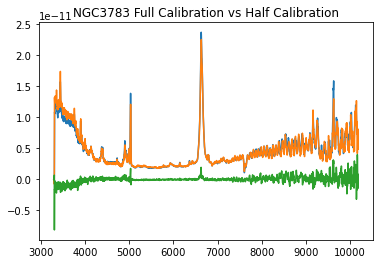

In [113]:
plt.plot(NGC_spectra[2][0],warped_spectra[1],label = 'full cal.')
plt.plot(NGC_spectra[2][0],warped_spectra[2],label = 'half cal.')
plt.plot(NGC_spectra[2][0],warped_spectra[1]-warped_spectra[2], label = 'full - half')
plt.title('NGC3783 Full Calibration vs Half Calibration')
plt.show()
#plt.plot(NGC_spectra[2][0],warped_spectra[2])
#plt.title('NGC3783 Half Calibration')
#plt.show()
#plt.plot(NGC_spectra[2][0][:-300],warped_spectra[1][:-300]-warped_spectra[2][:-300])
#plt.plot(NGC_spectra[2][0][:-300],warped_spectra_var[1][:-300])
#plt.plot(NGC_spectra[2][0][500:-1000],warped_spectra_var[1][500:-1000])
#plt.show()

#plt.plot(NGC_spectra[2][0],warped_spectra_var[1]-warped_spectra_var[2])
#plt.show
#plt.plot(NGC_spectra[2][0],warped_spectra_var[1])
#plt.show()
#plt.plot(NGC_spectra[2][0],near_warped_var[0])
#plt.show()
#plt.plot(NGC_spectra[2][0],warped_spectra_var[0])
#plt.show()
#plt.plot(NGC_spectra[2][0],near_warped_var[0]-warped_spectra_var[0])
#plt.show()

In [94]:
max(warped_spectra[2][1200:1800])
outlier_ind = np.argmax((NGC_g[0]))

2.2533202867212014e-11

In [37]:
spe = fits.open('../NGC3783_scaled.fits')

In [38]:
print(spe.info())
print(len(spe[0].data))

Filename: ../NGC3783_scaled.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (3000,)   float64   
  1                1 ImageHDU        38   (3000,)   float64   
  2                1 ImageHDU        38   (3000,)   float64   
  3                1 ImageHDU        38   (0,)      
  4                1 ImageHDU        38   (3000,)   float64   
  5                1 ImageHDU        38   (3000,)   float64   
  6                1 ImageHDU        38   (0,)      
  7                1 ImageHDU        38   (3000,)   float64   
  8                1 ImageHDU        38   (3000,)   float64   
  9                1 ImageHDU        38   (0,)      
 10                1 ImageHDU        38   (3000,)   float64   
 11                1 ImageHDU        38   (3000,)   float64   
 12                1 ImageHDU        38   (0,)      
 13                1 ImageHDU        38   (3000,)   float64   
 14                1 ImageHDU        38   (3000,)   float64   


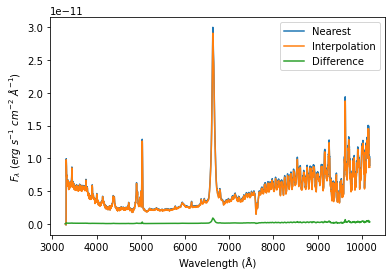

In [236]:
plt.plot(NGC_spectra[2][0],near_warped[0])
plt.plot(NGC_spectra[2][0],warped_spectra[0])
plt.plot(NGC_spectra[2][0],near_warped[0]-warped_spectra[0])
plt.xlabel('Wavelength (Å)')
plt.ylabel('$F_{\lambda} ~(erg ~s^{-1}~ cm^{-2} ~Å^{-1})$')
plt.legend(['Nearest','Interpolation','Difference'])
plt.savefig('../nearest_vs_interpolation.pdf')
plt.show()

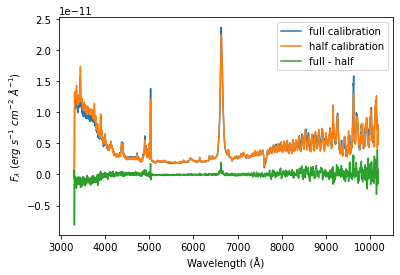

In [235]:
plt.plot(NGC_spectra[2][0],warped_spectra[1])
plt.plot(NGC_spectra[2][0],warped_spectra[2])
plt.plot(NGC_spectra[2][0],warped_spectra[1]-warped_spectra[2])

plt.legend(['full calibration','half calibration','full - half'])
plt.xlabel('Wavelength (Å)')
plt.ylabel('$F_{\lambda} ~(erg ~s^{-1}~ cm^{-2} ~Å^{-1})$')
plt.savefig('../NGC_calibration.pdf')
plt.show()

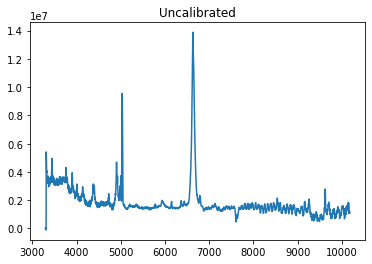

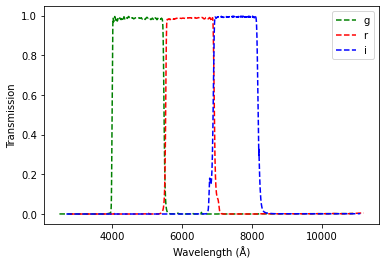

3297.0 10178.99987316132 3009
2500.599823 10897.6001 4666
2500.599823 11196.40015 4666
2500.599823 11097.3999 4666


In [176]:
plt.plot(NGC_spectra[2][0],NGC_spectra[0][0])
plt.title('Uncalibrated')
plt.show()
filterCurves = readFilterCurves(bands, filters)
plt.plot(filterCurves[bands[0]].wave, filterCurves[bands[0]].trans,'g' '--')
plt.plot(filterCurves[bands[1]].wave, filterCurves[bands[1]].trans,'r' '--')
plt.plot(filterCurves[bands[2]].wave, filterCurves[bands[2]].trans,'b' '--')
plt.legend(['g','r','i'])
plt.xlabel('Wavelength (Å)')
plt.ylabel('Transmission')
plt.show()
print(min(NGC_spectra[2][0]),max(NGC_spectra[2][0]), len(NGC_spectra[2][0]))
print(min(filterCurves[bands[0]].wave),max(filterCurves[bands[0]].wave),len(filterCurves[bands[0]].wave))
print(min(filterCurves[bands[0]].wave),max(filterCurves[bands[1]].wave),len(filterCurves[bands[0]].wave))
print(min(filterCurves[bands[0]].wave),max(filterCurves[bands[2]].wave),len(filterCurves[bands[0]].wave))

#plt.plot(NGC_spectra[2][0],scaling_func[0])
#plt.plot(4770,scaling[0][0],'og')
#plt.plot(6215,scaling[1][0],'or')
#plt.plot(7545,scaling[2][0],'ob')
#plt.show()

#plt.plot(NGC_spectra[2][0],warped_spectra[0])
#plt.title('Calibrated')
#plt.show()



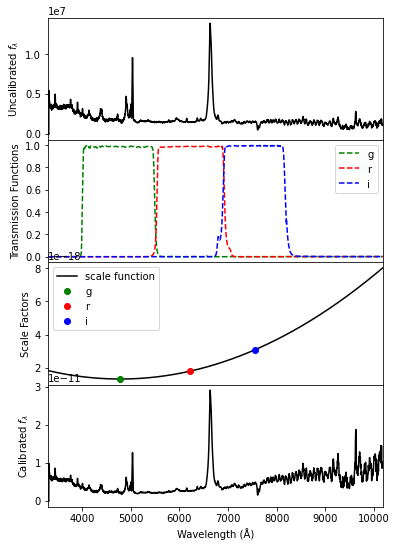

In [204]:

fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].plot(NGC_spectra[2][0],NGC_spectra[0][0],'k')
axs[0].set(ylabel='Uncalibrated $f_\lambda$')

filterCurves = readFilterCurves(bands, filters)
axs[1].plot(filterCurves[bands[0]].wave, filterCurves[bands[0]].trans,'g' '--')
axs[1].plot(filterCurves[bands[1]].wave, filterCurves[bands[1]].trans,'r' '--')
axs[1].plot(filterCurves[bands[2]].wave, filterCurves[bands[2]].trans,'b' '--')
axs[1].set_xlim([min(NGC_spectra[2][0]),max(NGC_spectra[2][0])])
axs[1].set(ylabel='Transmission Functions')
axs[1].legend(['g','r','i'])

axs[2].plot(NGC_spectra[2][0],scaling_func[0],'k')
axs[2].plot(4770,scaling[0][0],'og')
axs[2].plot(6215,scaling[1][0],'or')
axs[2].plot(7545,scaling[2][0],'ob')
axs[2].legend(['scale function','g','r','i'])
axs[2].set(ylabel='Scale Factors')

axs[3].plot(NGC_spectra[2][0],warped_spectra[0],'k')
axs[3].set(ylabel='Calibrated $f_\lambda$')
axs[3].set(xlabel='Wavelength (Å)')
fig.set_figheight(9)
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
plt.savefig('../Calib.pdf')
    



#plt.plot(NGC_spectra[2][0],scaling_func[0])
#plt.plot(4770,scaling[0][0],'og')
#plt.plot(6215,scaling[1][0],'or')
#plt.plot(7545,scaling[2][0],'ob')
#plt.show()

#plt.plot(NGC_spectra[2][0],warped_spectra[0])
#plt.title('Calibrated')
#plt.show()